# MPA-MLF: Final project

Made by Dmitrii Semenov, Josef Pecka

Step 1: Import libraries

In [10]:
# Import general libraries
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Import main functions for ML
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import Callback, ReduceLROnPlateau
from sklearn.model_selection import train_test_split


# Import Tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# Import confusion matrix fucntion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set plot font 
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

Step 2: Load input files

In [11]:
# Set dataset paths
dataset_dir = ""
train_dir = os.path.join(dataset_dir, "Train")
test_dir = os.path.join(dataset_dir, "Test")
labels_path = os.path.join(dataset_dir, "label_train.csv")
test_format_path = os.path.join(dataset_dir, "test_format.csv")

# Load labels file
labels_df = pd.read_csv(labels_path)

# Prepare containers
X = []
y = []

# Loop through each file ID
for _, row in labels_df.iterrows():
    file_name = f"{row['ID']}.npy"
    file_path = os.path.join(train_dir, file_name)
    try:
        sample = np.load(file_path)
        X.append(sample)
        y.append(row['target'])
    except Exception as e:
        print(f"[Error] Could not load {file_name}: {e}")

# Convert to NumPy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print(f"[INFO] Loaded {X.shape[0]} samples of shape {X.shape[1:]}")
print(f"[INFO] Max value of X data {np.max(X)}")
print(f"[INFO] Min value of X data {np.min(X)}")


[INFO] Loaded 1491 samples of shape (72, 48)
[INFO] Max value of X data 76.52984619140625
[INFO] Min value of X data -66.49512481689453


Step 3: Data preprocessing

In [49]:
# Z-score normalization
X = X.astype("float32")
X_mean = X.mean()
X_std = X.std()
X = (X - X_mean) / X_std

print(f"[INFO] Mean value of data after Z-score normalizations: {np.mean(X)}")

# Reshape for CNN input
X = X.reshape((-1, 72, 48, 1))

# One-hot encode labels
NUM_CLASSES = 3
y = to_categorical(y, NUM_CLASSES)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y,
    test_size=0.2,
    stratify=y.argmax(axis=1),
    random_state=42
)

# Print result
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")

[INFO] Mean value of data after Z-score normalizations: -5.460464969075929e-09
X_train shape: (1192, 72, 48, 1), X_val shape: (299, 72, 48, 1)
y_train shape: (1192, 3, 3), y_val shape: (299, 3, 3)


Visualize class distribution in training and validation sets

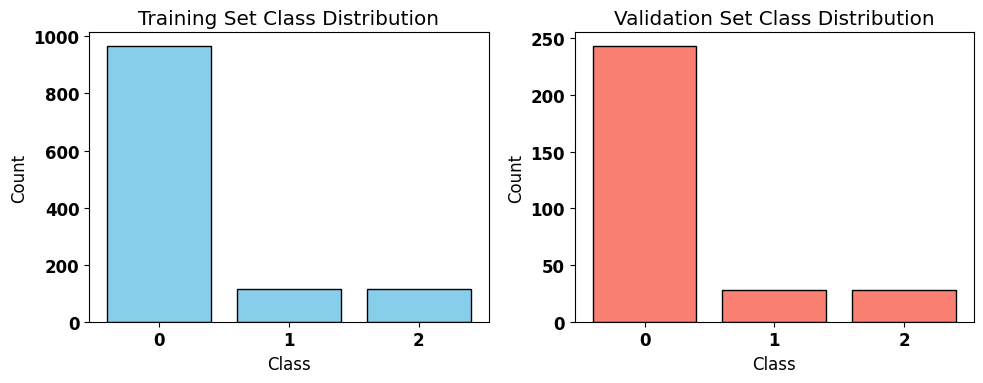

In [13]:
# Convert one-hot labels back to class indices
y_train_labels = y_train.argmax(axis=1)
y_val_labels = y_val.argmax(axis=1)

# Plot
plt.figure(figsize=(10, 4))

# Training set
plt.subplot(1, 2, 1)
plt.hist(y_train_labels, bins=np.arange(NUM_CLASSES + 1) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
plt.xticks(range(NUM_CLASSES))
plt.title("Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

# Validation set
plt.subplot(1, 2, 2)
plt.hist(y_val_labels, bins=np.arange(NUM_CLASSES + 1) - 0.5, rwidth=0.8, color='salmon', edgecolor='black')
plt.xticks(range(NUM_CLASSES))
plt.title("Validation Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

Step 4: CNN model definition + Keras Tuner

In [25]:
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Conv2D(
        filters=hp.Choice("filters_1", [64, 128, 256]),
        kernel_size=hp.Choice("kernel_size_1", [3, 5]),
        activation='relu',
        input_shape=(72, 48, 1)
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    
    # Optional Conv layer 2
    if hp.Boolean("add_conv_2"):
        model.add(Conv2D(
            filters=hp.Choice("filters_2", [64, 128, 256]),
            kernel_size=hp.Choice("kernel_size_2", [3, 5]),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))

    # Optional Conv layer 3
    if hp.Boolean("add_conv_3"):
        model.add(Conv2D(
            filters=hp.Choice("filters_3", [64, 128, 256]),
            kernel_size=hp.Choice("kernel_size_3", [3, 5]),
            activation='relu'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    
    model.add(Dense(
        units=hp.Choice("dense_units", [64, 128, 256]),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float("dropout", 0.2, 0.5, step=0.1)))

    model.add(Dense(3, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling='log')),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

Step 5: Run Keras Tuner to Find the Best Hyperparameters


In [26]:
# Define custom EarlyStopping calback (monitors if "val_accuracy" is above threshold)
class EarlyStoppingWithThreshold(Callback):
    def __init__(self, monitor='val_accuracy', patience=5, threshold=0.5, verbose=1):
        super().__init__()
        self.monitor = monitor
        self.patience = patience
        self.threshold = threshold
        self.verbose = verbose
        self.wait = 0
        self.best = -np.inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            return
        
        # Only start checking if threshold is passed
        if current < self.threshold:
            if self.verbose:
                print(f"Epoch {epoch + 1}: {self.monitor} below threshold {self.threshold:.2f}, skipping early stop check.")
            return
        
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"\nEpoch {epoch + 1}: early stopping triggered. Best {self.monitor}: {self.best:.4f}")
                self.model.stop_training = True

In [27]:
# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=25,            # You can increase this for better results
    executions_per_trial=1,    # Runs per model setting
    directory='tuner_results',
    project_name='cnn_tuning'
)

# Tuner summary
tuner.search_space_summary()

# Run the tuner
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStoppingWithThreshold(monitor='val_accuracy', patience=5, threshold=0.5, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    ],
    verbose=2
)

# Show the best model found
tuner.results_summary()

# Get the best model
top_models = tuner.get_best_models(num_models=5)

Trial 25 Complete [00h 00m 58s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 01h 06m 27s
Results summary
Results in tuner_results/cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
filters_1: 128
kernel_size_1: 3
add_conv_2: True
add_conv_3: False
dense_units: 128
dropout: 0.2
learning_rate: 0.0006982658253988871
filters_2: 64
kernel_size_2: 3
Score: 1.0

Trial 01 summary
Hyperparameters:
filters_1: 256
kernel_size_1: 5
add_conv_2: False
add_conv_3: True
dense_units: 64
dropout: 0.2
learning_rate: 0.0003711901475345014
filters_2: 256
kernel_size_2: 5
filters_3: 64
kernel_size_3: 3
Score: 1.0

Trial 05 summary
Hyperparameters:
filters_1: 128
kernel_size_1: 3
add_conv_2: True
add_conv_3: True
dense_units: 256
dropout: 0.30000000000000004
learning_rate: 0.00912785730912851
filters_2: 256
kernel_size_2: 5
filters_3: 64
kernel_size_3: 5
Score: 1.0

Trial 07 summary
Hyperparameters:
filters_1: 128
kerne

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Take the best model (the easiest and with high accuracy)

In [28]:
for i, model in enumerate(top_models):
    model_params = model.count_params()
    print(f"Model {i+1} - Total trainable parameters: {model_params}")

best_model = min(top_models, key=lambda m: m.count_params())

Model 1 - Total trainable parameters: 1387075
Model 2 - Total trainable parameters: 811075
Model 3 - Total trainable parameters: 1397059
Model 4 - Total trainable parameters: 4838787
Model 5 - Total trainable parameters: 1312515


Step 6: Final training of the best model and evaluation

In [41]:
# Data about best model
print(best_model.summary())

# Retrain the best model
history = best_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStoppingWithThreshold(monitor='val_accuracy', patience=10, threshold=0.5, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    ],
    verbose=2
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 68, 44, 256)    │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 68, 44, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 34, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 20, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       655,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 811,075 (3.09 MB)

 Trainable params: 810,435 (3.09 MB)

 Non-trainable params: 640 (2.50 KB)

None
Epoch 1/50
38/38 - 7s - 179ms/step - accuracy: 0.9841 - loss: 0.0447 - val_accuracy: 0.9465 - val_loss: 0.1511 - learning_rate: 3.7119e-04
Epoch 2/50
38/38 - 6s - 150ms/step - accuracy: 0.9908 - loss: 0.0273 - val_accuracy: 0.9933 - val_loss: 0.0202 - learning_rate: 3.7119e-04
Epoch 3/50
38/38 - 6s - 148ms/step - accuracy: 0.9899 - loss: 0.0257 - val_accuracy: 0.9833 - val_loss: 0.0359 - learning_rate: 3.7119e-04
Epoch 4/50
38/38 - 6s - 150ms/step - accuracy: 0.9908 - loss: 0.0195 - val_accuracy: 0.9766 - val_loss: 0.0912 - learning_rate: 3.7119e-04
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00018559506861492991.
38/38 - 6s - 150ms/step - accuracy: 0.9941 - loss: 0.0103 - val_accuracy: 0.9732 - val_loss: 0.0912 - learning_rate: 3.7119e-04
Epoch 6/50
38/38 - 6s - 149ms/step - accuracy: 0.9950 - loss: 0.0112 - val_accuracy: 0.9900 - val_loss: 0.0324 - learning_rate: 1.8560e-04
Epoch 7/50
38/38 - 6s - 149ms/step - accuracy: 0.9941 - loss: 0.0132 - val_accuracy

In [42]:
# Info about model accuracy
val_preds = best_model.predict(X_val)
val_pred_labels = val_preds.argmax(axis=1)
val_true_labels = y_val.argmax(axis=1)

print("Predicted label distribution:", np.bincount(val_pred_labels))
print("Actual val label distribution:", np.bincount(val_true_labels))

# Check accuracy manually
manual_acc = np.mean(val_pred_labels == val_true_labels)
print(f"Manual validation accuracy: {manual_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted label distribution: [243  26  30]
Actual val label distribution: [243  28  28]
Manual validation accuracy: 0.9933


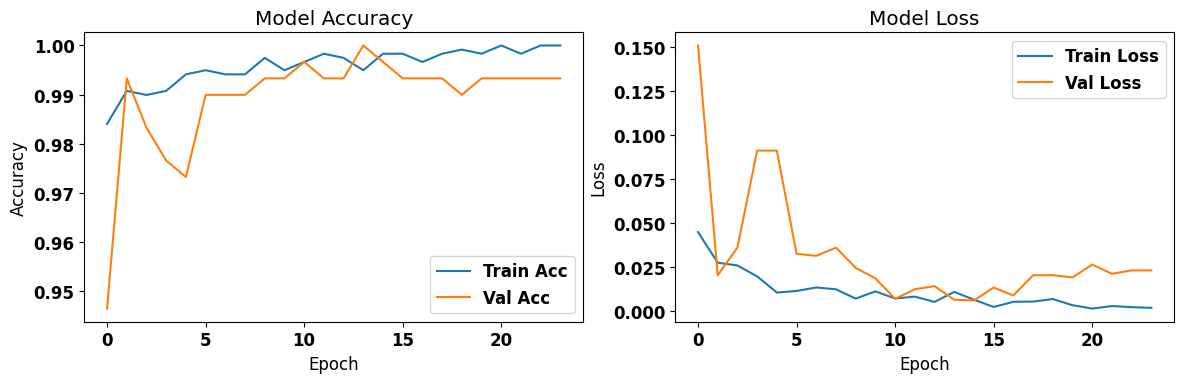

In [43]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


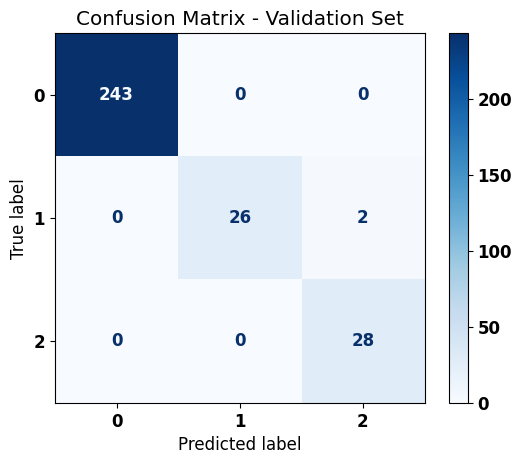

In [44]:
# Confusion matrix
val_preds = best_model.predict(X_val)
val_pred_labels = val_preds.argmax(axis=1)
val_true_labels = y_val.argmax(axis=1)

# Compute and plot confusion matrix
cm = confusion_matrix(val_true_labels, val_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.show()

Step 7: Predictions on test set

In [50]:
# Load test filenames
test_file_names = sorted([f for f in os.listdir(test_dir) if f.endswith(".npy")])

# Load and normalize test data
X_test = []

for fname in test_file_names:
    path = os.path.join(test_dir, fname)
    sample = np.load(path)
    X_test.append(sample)

X_test = np.array(X_test).astype("float32")

# Apply Z-score normalization using train mean/std
X_test = (X_test - X_mean) / X_std

# Reshape for CNN input
X_test = X_test.reshape((-1, 72, 48, 1))

print(f"Loaded {X_test.shape[0]} test samples")

Loaded 120 test samples


In [51]:
# Predict class probabilities
y_test_probs = best_model.predict(X_test)

# Convert to class labels (0, 1, 2)
y_test_pred = y_test_probs.argmax(axis=1)

# Preview
print("Predicted labels:", y_test_pred[:10])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted labels: [1 0 0 0 0 0 1 0 0 1]


Step 8: Save Kaggle Submission File

In [54]:
# Load test_format.csv
test_format_path = os.path.join(dataset_dir, "test_format.csv")
submission_df = pd.read_csv(test_format_path)

# Add predicted labels
submission_df["target"] = y_test_pred

# Save to CSV for Kaggle
submission_file = "submission.csv"
submission_df.to_csv(submission_file, index=False)

print(f"[INFO] Submission file saved: {submission_file}")
print(submission_df)

[INFO] Submission file saved: submission.csv
      ID  target
0      0       1
1      1       0
2      2       0
3      3       0
4      4       0
..   ...     ...
115  115       0
116  116       0
117  117       0
118  118       0
119  119       0

[120 rows x 2 columns]
